In [1]:
from sage.all import *
import numpy as np
from numpy.linalg import inv
from scipy.sparse import block_diag
from tqdm import tqdm

In [5]:
def L(r):

    r = np.roll(r, -1)
    r[-1] = 0
    return r.astype(int)

def binomials(r, s):
    return prod([binomial(int(r[i]), int(s[i])) for i in range(r.shape[0])])

def red(r, s):
    return (r - s + L(s)).astype(int)

def gale_ryser(p, q):

    if np.sum(p) != np.sum(q):
        return False
    else:

        passed = True

        q_prime = np.array([np.count_nonzero(q >= i) for i in range(q.shape[0])])
        for j in range(q.shape[0]):
            if np.sum(q_prime[:j]) < np.sum(p[:j]):
                passed = False

        return passed
    
def comps_lessthan(k, s):

    n = s.shape[0]
    comps = WeightedIntegerVectors(k, np.ones(n))
    comps_less = []
    for comp in comps:
        if np.all(np.less_equal(comp, s)):
            comps_less.append(np.array(comp).astype(int))

    return comps_less

def un_bar(q_bar):

    q = np.concatenate(tuple([i+1 * np.ones(q_bar[i]) for i in range(q_bar.shape[0])]))
    return np.sort(q)[::-1]

def N(p , q):

    # print(f'finding number of matrices for p = {p}, q = {q}')

    if np.sum(p) != np.sum(q):
        return 0
    
    elif np.sum(p) == 0:
        return 1
    
    else:
        n = np.sum(p)

        # Check Gale-Ryser Criterion
        if gale_ryser(p, q):
            # Find vector of counts
            q_bar = np.array([np.count_nonzero(q == i) for i in range(1, n+1)]).astype(int)

            # Find compositions of p_1 less than or equal to q_bar
            comps = comps_lessthan(p[0], q_bar)

            num = 0
            for comp in comps:
                num += binomials(q_bar, comp) * N(L(p), un_bar(red(q_bar, comp)))
            return num
        
        else:
            return 0 

In [351]:
class InvariantInnerProduct:

    def __init__(self, d, n):
        self.dimension = d
        self.degree = int(n) 

        self.parts = Partitions(n).list()

        if n < 11:
            self.C = np.load(f'C-Matrices/IP-C-Matrices/C_{n}.npy')

        else:
            B = inv(self.change_basis())
            self.C = B @ self.C_star() @ B

    def C_star(self):
        rank = len(self.parts)

        C = np.zeros((rank, rank))

        for i in range(rank):
            part  = np.array(self.parts[i])
            size = int(np.sum(np.array(part)))

            coeff = np.prod([factorial(np.count_nonzero(part == i)) for i in range(size)])/np.prod([factorial(int(part[i])) for i in range(len(part))])
            
            C[i][i] = coeff

        #print('found C*')
        return C
    
    def change_basis(self):

        mat = np.zeros((len(self.parts), len(self.parts)))

        for i in range(len(self.parts)):
            for j in range(len(self.parts)):
                v = N(np.array(list(self.parts[i])), np.array(list(self.parts[j])))
                mat[i][j] = v
                mat[i][j] = v

        return mat
    

    def elementary_symmetric_polynomials(self, x):

        mat = np.zeros((self.degree+1, self.dimension+1))

        mat[0] = np.ones(self.dimension+1)
        
        for i in range(self.degree):
            #print(f'row {i}')
            for j in range(i, self.dimension):
                mat[i+1][j+1] = x[j]*mat[i][j] + mat[i+1][j]

        return mat[:, self.dimension]
    
    def evaluate(self, x, y):

        esp_x = self.elementary_symmetric_polynomials(x)
        esp_y = self.elementary_symmetric_polynomials(y)

        #print('ESP Computed')

        basis_x = []
        basis_y = []

        for i in range(len(self.parts)):
            part = self.parts[i]
            basis_x.append(np.prod([esp_x[p] for p in part]))
            basis_y.append([np.prod([esp_y[p] for p in part])])

        return (np.array(basis_y).T @ self.C @ np.array(basis_x))[0]

In [42]:
ip = InvariantInnerProduct(20, 0)
np.save('IP-C-Matrices/C_0', ip.C)

In [43]:
ip.evaluate(np.ones(20), 2*np.ones(20))

1.0

In [44]:
WeightedIntegerVectors(10, np.ones(3)).list()

[[0, 0, 10.0],
 [0, 1.0, 9.0],
 [1.0, 0.0, 9.0],
 [0, 2.0, 8.0],
 [1.0, 1.0, 8.0],
 [2.0, 0.0, 8.0],
 [0, 3.0, 7.0],
 [1.0, 2.0, 7.0],
 [2.0, 1.0, 7.0],
 [3.0, 0.0, 7.0],
 [0, 4.0, 6.0],
 [1.0, 3.0, 6.0],
 [2.0, 2.0, 6.0],
 [3.0, 1.0, 6.0],
 [4.0, 0.0, 6.0],
 [0, 5.0, 5.0],
 [1.0, 4.0, 5.0],
 [2.0, 3.0, 5.0],
 [3.0, 2.0, 5.0],
 [4.0, 1.0, 5.0],
 [5.0, 0.0, 5.0],
 [0, 6.0, 4.0],
 [1.0, 5.0, 4.0],
 [2.0, 4.0, 4.0],
 [3.0, 3.0, 4.0],
 [4.0, 2.0, 4.0],
 [5.0, 1.0, 4.0],
 [6.0, 0.0, 4.0],
 [0, 7.0, 3.0],
 [1.0, 6.0, 3.0],
 [2.0, 5.0, 3.0],
 [3.0, 4.0, 3.0],
 [4.0, 3.0, 3.0],
 [5.0, 2.0, 3.0],
 [6.0, 1.0, 3.0],
 [7.0, 0.0, 3.0],
 [0, 8.0, 2.0],
 [1.0, 7.0, 2.0],
 [2.0, 6.0, 2.0],
 [3.0, 5.0, 2.0],
 [4.0, 4.0, 2.0],
 [5.0, 3.0, 2.0],
 [6.0, 2.0, 2.0],
 [7.0, 1.0, 2.0],
 [8.0, 0.0, 2.0],
 [0, 9.0, 1.0],
 [1.0, 8.0, 1.0],
 [2.0, 7.0, 1.0],
 [3.0, 6.0, 1.0],
 [4.0, 5.0, 1.0],
 [5.0, 4.0, 1.0],
 [6.0, 3.0, 1.0],
 [7.0, 2.0, 1.0],
 [8.0, 1.0, 1.0],
 [9.0, 0.0, 1.0],
 [0, 10.0, 0.0],
 [1.0, 9.0, 0.

In [243]:
class SetInvariantClassification:

    def __init__(self, d, k, n):
        self.d = d
        self.k = k
        self.degree = n
        
        self.comps = []
        self.ips = []
        for i in range(self.degree + 1):
            self.comps.extend(WeightedIntegerVectors(i, np.ones(k)).list())
            self.ips.append(InvariantInnerProduct(d, i))

    def evaluate(self, x, y):
        
        val = 0
        for i in range(len(self.comps)):
            comp = self.comps[i]

            inner_products = [self.ips[int(comp[j])].evaluate(x[:, j], y[:, j]) for j in range(self.k)]
            val += np.prod(inner_products)/np.prod([factorial(int(c)) for c in comp])
            
        return val

    def matrix(self, X, Y):

        mat = np.zeros((X.shape[0], Y.shape[0]))  
        for i in tqdm(range(X.shape[0])):
            #print(f'Row {i}')
            for j in range(Y.shape[0]):
            #    print(f'column {j}')
                mat[i][j] = self.evaluate(X[i], Y[j])

        return mat
    
    def gram_matrix(self, X):
        mat = np.zeros((X.shape[0], X.shape[0]))

        for i in tqdm(range(X.shape[0])):
            #print(f'Row {i}')
            for j in range(i, X.shape[0]):
                v = self.evaluate(X[i], X[j])
                mat[i][j] = v
                mat[j][i] = v

        return mat

    def predict(self, X):

        P = self.matrix(X, self.train_data)

        return np.sign(P @ self.alpha)

    def train(self, X, y, lam):

        N = X.shape[0]
        M = self.gram_matrix(X)

        alpha = np.linalg.solve(M + lam * np.eye(N), y)

        self.alpha = alpha
        self.train_data = X
        self.train_values = y
        self.training_accuracy = 1-np.count_nonzero(y - np.sign(M@alpha))/X.shape[0]
    
    def accuracy(self, X, y):    
        return 1-np.count_nonzero(y - self.predict(X))/X.shape[0]


        


In [197]:
sik = SetInvariantClassification(100, 3, 5)

## Point Cloud Data

Trying to classify point clouds as either isotropic or anisotropic

In [202]:
def point_cloud_data(n_samples, d_points, k):

    X = np.zeros((n_samples, d_points, k))
    y = 2*np.random.binomial(1, 0.5, n_samples) - 1

    for i in range(n_samples):
        pc = np.random.randn(d_points, k)

        if y[i] == 1:
            X[i] = pc
        
        else:
            M = np.random.randn(k, k)
            X[i] = pc @ (M@M.T)

    
    return X, y



In [211]:
train2d_X, train2d_y= point_cloud_data(1000, 100, 2)
test2d_X, test2d_y = point_cloud_data(100, 100, 2)

In [212]:
sik_2 = SetInvariantClassification(10, 2, 4)

In [213]:
sik_2.train(train2d_X, train2d_y, 0.01)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [214]:
sik_2.accuracy(test2d_X, test2d_y)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99


0.73

In [209]:
sik.train(train2d_X, train2d_y, 0.01)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [210]:
sik.accuracy(test2d_X, test2d_y)

Row 0


Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99


0.71

In [142]:
np.random.randn(3, 3)

array([[ 0.2824057 ,  1.40746179,  0.69790893],
       [ 1.089748  ,  1.07723957, -0.85443244],
       [-0.7848601 , -0.47701032, -1.18715956]])

In [163]:
train_X, train_y = point_cloud_data(1000, 50)

In [164]:
test_X, test_y = point_cloud_data(100, 50)

In [2]:
from datetime import datetime
from sklearn.model_selection import KFold

In [151]:
degs = list(range(1, 6))
n_samples = [200, 400, 600, 800, 1000]
lams = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
folds  = 5

kfold = KFold(n_splits=folds)

In [166]:
train_accuracies = np.zeros((5, 5))
test_accuracies = np.zeros((5, 5))

In [167]:
best_lams = np.zeros((5, 5))

In [ ]:
for j in range(len(n_samples)):
    n = n_samples[j]
    X = train_X[:n]
    y = train_y[:n]

    print(f'{n} Samples')

    for k in range(2, len(degs)):
        if train_accuracies[j][k] == 0:
            m = degs[k]
            invariant_kernel = SetInvariantClassification(10, 3, m)
            print(f'Degree {m}')

            invariant_val_error = np.zeros((folds, len(lams)))

            fold = 0
            for train_index, test_index in kfold.split(X):
                now = datetime.now()

                current_time = now.strftime("%H:%M:%S")
                print("Current Time =", current_time)
                print('fold', fold)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                for l in range(len(lams)):

                    invariant_kernel.train(train_data, train_values, lams[l])
                    invariant_val_error[fold][l] = invariant_kernel.accuracy(val_data, val_values)


                fold += 1

            best_lam_invariant = lams[np.argmax(np.mean(invariant_val_error, axis=1))]
            best_lams[j][k] = best_lam_invariant
            invariant_kernel.train(X, y, best_lam_invariant)

            train_accuracies[j][k] = invariant_kernel.training_accuracy
            test_accuracies[j][k] = invariant_kernel.accuracy(test_X, test_y)


            print('Train Accuracies \n', train_accuracies)
            print('Test Accuracies \n', test_accuracies)
            print('Lambdas \n', best_lams)
            np.save('Data/sets-d50-test.npy', test_accuracies)
            np.save('Data/sets-d50-train.npy', train_accuracies)
            np.save('Data/sets-d50-lambda.npy', best_lams)

200 Samples
Degree 5
Current Time = 09:28:22
fold 0
Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10


KeyboardInterrupt: 

In [165]:
np.save('Data/sets-d10-test.npy', test_accuracies)
np.save('Data/sets-d10-train.npy', train_accuracies)
np.save('Data/sets-d10-lambda.npy', best_lams)
np.savez('Data/sets-d50-train.npz', x=train_X, y=train_y)
np.savez('Data/sets-d50-test.npz', x=test_X, y=test_y)

# Classifying Point Clouds from Two Distributions

Generate point clouds from either a standard normal or a fixed anisotropic normal distribution. Want to classify point clouds according to which distribution they are drawn from.

In [231]:
def two_distributions_data(n_samples, d_points):

    X = np.zeros((n_samples, d_points, 2))
    y = 2*np.random.binomial(1, 0.5, n_samples) - 1

    for i in range(n_samples):
        pc = np.random.randn(d_points, 2)

        if y[i] == 1:
            X[i] = pc
        
        else:
            X[i] = pc @ np.array([[1, 0.6], [0.6, 2]])

    return X, y

In [238]:
X, y = point_cloud_data(1100, 50, 2)
train_X = X[:1000]
test_X = X[1000:]
train_y = y[:1000]
test_y = y[1000:]

In [239]:
np.savez('Data/2D-Isotropic-Classification-Train', x=train_X, y=train_y)
np.savez('Data/2D-Isotropic-Classification-Test', x=test_X, y=test_y)

Determining Hyperparameters

In [3]:
degs = list(range(1, 6))
n_samples = [200, 400, 600, 800, 1000]
lams = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
folds  = 4

kfold = KFold(n_splits=folds)

In [264]:
avg_val_accuracies = np.zeros((5, 5))
best_lams = np.zeros((5, 5))

In [271]:
for i in range(len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetInvariantClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        val_accuracies = np.zeros((folds, len(lams)))

        if best_lams[i][j] == 0:
            fold = 0
            for train_index, test_index in kfold.split(X):
                now = datetime.now()

                current_time = now.strftime("%H:%M:%S")
                print("Current Time =", current_time)
                print('fold', fold)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                kernel_matrix = kernel.gram_matrix(train_data)
                prediction_matrix = kernel.matrix(val_data, train_data)

                for l in range(len(lams)):
                    alpha = np.linalg.solve(kernel_matrix + lams[l]*np.eye(kernel_matrix.shape[0]), train_values)
                    val_accuracies[fold][l] = 1 - np.count_nonzero(val_values - np.sign(prediction_matrix@alpha))/val_data.shape[0]

                fold += 1

            best_lam = lams[np.argmax(np.mean(val_accuracies, axis=0))]
            best_lams[i][j] = best_lam
            avg_val_accuracies[i][j] = np.max(np.mean(val_accuracies, axis=0))

            print('Best Avg. Accuracy \n', avg_val_accuracies)
            print('Best Lambda \n', best_lams)

            np.save('Data/2D-Isotropic-Classification-val-acc.npy', avg_val_accuracies)
            np.save('Data/2D-Isotropic-Classification-lambda.npy', best_lams)


Degree 1
200 Samples
400 Samples
Current Time = 18:11:10
fold 0


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Current Time = 18:12:01
fold 1


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Current Time = 18:12:49
fold 2


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Current Time = 18:13:37
fold 3


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
600 Samples
Current Time = 18:14:22
fold 0


100%|██████████| 150/150 [00:38<00:00,  3.85it/s]


Current Time = 18:16:03
fold 1


100%|██████████| 150/150 [00:39<00:00,  3.78it/s]


Current Time = 18:17:43
fold 2


100%|██████████| 150/150 [00:38<00:00,  3.87it/s]


Current Time = 18:19:22
fold 3


100%|██████████| 150/150 [00:38<00:00,  3.87it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
800 Samples
Current Time = 18:21:01
fold 0


100%|██████████| 200/200 [01:07<00:00,  2.96it/s]


Current Time = 18:23:55
fold 1


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


Current Time = 18:26:50
fold 2


100%|██████████| 200/200 [01:10<00:00,  2.83it/s]


Current Time = 18:29:45
fold 3


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
1000 Samples
Current Time = 18:32:38
fold 0


100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


Current Time = 18:37:13
fold 1


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Current Time = 18:41:49
fold 2


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


Current Time = 18:46:23
fold 3


100%|██████████| 250/250 [01:46<00:00,  2.36it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.         0.         0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
Degree 2
200 Samples
Current Time = 18:50:55
fold 0


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Current Time = 18:51:30
fold 1


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


Current Time = 18:52:04
fold 2


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


Current Time = 18:52:37
fold 3


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.755      0.         0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
400 Samples
Current Time = 18:53:11
fold 0


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Current Time = 18:55:19
fold 1


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Current Time = 18:57:24
fold 2


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Current Time = 18:59:29
fold 3


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.755      0.7425     0.         0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
600 Samples
Current Time = 19:01:33
fold 0


100%|██████████| 150/150 [01:47<00:00,  1.40it/s]


Current Time = 19:06:06
fold 1


100%|██████████| 150/150 [01:47<00:00,  1.40it/s]


Current Time = 19:10:44
fold 2


100%|██████████| 150/150 [01:48<00:00,  1.39it/s]


Current Time = 19:15:17
fold 3


100%|██████████| 150/150 [01:47<00:00,  1.40it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.755      0.7425     0.73       0.         0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
800 Samples
Current Time = 19:19:50
fold 0


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Current Time = 19:27:51
fold 1


100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Current Time = 19:35:51
fold 2


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Current Time = 19:43:54
fold 3


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.755      0.7425     0.73       0.7375     0.        ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
1000 Samples
Current Time = 19:52:00
fold 0


100%|██████████| 250/250 [04:58<00:00,  1.19s/it]


Current Time = 20:04:39
fold 1


100%|██████████| 250/250 [05:00<00:00,  1.20s/it]


Current Time = 20:17:21
fold 2


100%|██████████| 250/250 [04:59<00:00,  1.20s/it]


Current Time = 20:29:56
fold 3


100%|██████████| 250/250 [06:38<00:00,  1.59s/it]

Best Avg. Accuracy 
 [[0.41       0.455      0.475      0.47875    0.478     ]
 [0.755      0.7425     0.73       0.7375     0.744     ]
 [0.79       0.7525     0.73       0.72625    0.738     ]
 [0.795      0.79       0.77333333 0.77125    0.766     ]
 [0.71       0.7525     0.76       0.7375     0.732     ]]
Best Lambda 
 [[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-01 1.e-02 1.e-04 1.e-03]
 [1.e-04 1.e-01 1.e-02 1.e-01 1.e-02]
 [1.e-03 1.e-01 1.e-01 1.e-01 1.e-01]]
Degree 3
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 4
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 5
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples


In [258]:
data = np.load('Data/2D-Isotropic-Classification-Train.npz')
train_X = data['x']
train_y = data['y']

In [259]:
ker = SetInvariantClassification(50, 2, 3)

In [260]:
ker.train(train_X, train_y, 0.01)

100%|██████████| 1000/1000 [29:44<00:00,  1.78s/it]


In [261]:
ker.accuracy(test_X, test_y)

100%|██████████| 100/100 [06:02<00:00,  3.62s/it]


0.69

In [262]:
ker.training_accuracy

0.747

# Non-Invariant

In [279]:
class SetClassification:

    def __init__(self, d, k, n):
        self.d = d
        self.k = k
        self.degree = n

    def evaluate(self, x, y):
        
        x = x.flatten()
        y = y.flatten()
            
        return np.sum([(x@y)**(i+1)/factorial(i+1) for i in range(self.degree)])

    def matrix(self, X, Y):

        mat = np.zeros((X.shape[0], Y.shape[0]))  
        for i in tqdm(range(X.shape[0])):
            #print(f'Row {i}')
            for j in range(Y.shape[0]):
            #    print(f'column {j}')
                mat[i][j] = self.evaluate(X[i], Y[j])

        return mat
    
    def gram_matrix(self, X):
        mat = np.zeros((X.shape[0], X.shape[0]))

        for i in tqdm(range(X.shape[0])):
            #print(f'Row {i}')
            for j in range(i, X.shape[0]):
                v = self.evaluate(X[i], X[j])
                mat[i][j] = v
                mat[j][i] = v

        return mat

    def predict(self, X):

        P = self.matrix(X, self.train_data)

        return np.sign(P @ self.alpha)

    def train(self, X, y, lam):

        N = X.shape[0]
        M = self.gram_matrix(X)

        alpha = np.linalg.solve(M + lam * np.eye(N), y)

        self.alpha = alpha
        self.train_data = X
        self.train_values = y
        self.training_accuracy = 1-np.count_nonzero(y - np.sign(M@alpha))/X.shape[0]
    
    def accuracy(self, X, y):    
        return 1-np.count_nonzero(y - self.predict(X))/X.shape[0]


        


In [280]:
avg_val_accuracies = np.zeros((5, 5))
best_lams = np.zeros((5, 5))

In [282]:
for i in range(len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        val_accuracies = np.zeros((folds, len(lams)))

        if best_lams[i][j] == 0:
            fold = 0
            for train_index, test_index in kfold.split(X):
                now = datetime.now()

                current_time = now.strftime("%H:%M:%S")
                print("Current Time =", current_time)
                print('fold', fold)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                kernel_matrix = kernel.gram_matrix(train_data)
                prediction_matrix = kernel.matrix(val_data, train_data)

                for l in range(len(lams)):
                    alpha = np.linalg.solve(kernel_matrix + lams[l]*np.eye(kernel_matrix.shape[0]), train_values)
                    val_accuracies[fold][l] = 1 - np.count_nonzero(val_values - np.sign(prediction_matrix@alpha))/val_data.shape[0]

                fold += 1

            best_lam = lams[np.argmax(np.mean(val_accuracies, axis=0))]
            best_lams[i][j] = best_lam
            avg_val_accuracies[i][j] = np.max(np.mean(val_accuracies, axis=0))

            print('Best Avg. Accuracy \n', avg_val_accuracies)
            print('Best Lambda \n', best_lams)

            np.save('Data/Non-Invariant-2D-Isotropic-Classification-val-acc.npy', avg_val_accuracies)
            np.save('Data/Non-Invariant-2D-Isotropic-Classification-lambda.npy', best_lams)

Degree 1
200 Samples
Current Time = 15:09:20
fold 0


100%|██████████| 50/50 [00:00<00:00, 162.60it/s]


Current Time = 15:09:21
fold 1


100%|██████████| 50/50 [00:00<00:00, 89.31it/s]


Current Time = 15:09:22
fold 2


100%|██████████| 50/50 [00:00<00:00, 171.97it/s]


Current Time = 15:09:23
fold 3


100%|██████████| 50/50 [00:00<00:00, 111.16it/s]


Best Avg. Accuracy 
 [[0.485      0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
400 Samples
Current Time = 15:09:25
fold 0


100%|██████████| 100/100 [00:02<00:00, 48.95it/s]


Current Time = 15:09:30
fold 1


100%|██████████| 100/100 [00:00<00:00, 118.90it/s]


Current Time = 15:09:33
fold 2


100%|██████████| 100/100 [00:00<00:00, 122.45it/s]


Current Time = 15:09:35
fold 3


100%|██████████| 100/100 [00:00<00:00, 123.05it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
600 Samples
Current Time = 15:09:38
fold 0


100%|██████████| 150/150 [00:02<00:00, 66.03it/s]


Current Time = 15:09:44
fold 1


100%|██████████| 150/150 [00:01<00:00, 80.09it/s]


Current Time = 15:09:49
fold 2


100%|██████████| 150/150 [00:01<00:00, 84.04it/s]


Current Time = 15:09:54
fold 3


100%|██████████| 150/150 [00:01<00:00, 85.11it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
800 Samples
Current Time = 15:09:58
fold 0


100%|██████████| 200/200 [00:03<00:00, 64.09it/s]


Current Time = 15:10:07
fold 1


100%|██████████| 200/200 [00:04<00:00, 47.65it/s]


Current Time = 15:10:18
fold 2


100%|██████████| 200/200 [00:03<00:00, 61.02it/s]


Current Time = 15:10:27
fold 3


100%|██████████| 200/200 [00:03<00:00, 58.71it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
1000 Samples
Current Time = 15:10:35
fold 0


100%|██████████| 250/250 [00:04<00:00, 52.27it/s]


Current Time = 15:10:49
fold 1


100%|██████████| 250/250 [00:05<00:00, 49.15it/s]


Current Time = 15:11:02
fold 2


100%|██████████| 250/250 [00:05<00:00, 48.61it/s]


Current Time = 15:11:16
fold 3


100%|██████████| 250/250 [00:05<00:00, 49.69it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.         0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
Degree 2
200 Samples
Current Time = 15:11:28
fold 0


100%|██████████| 50/50 [00:00<00:00, 170.47it/s]


Current Time = 15:11:29
fold 1


100%|██████████| 50/50 [00:00<00:00, 104.45it/s]


Current Time = 15:11:30
fold 2


100%|██████████| 50/50 [00:00<00:00, 83.23it/s] 


Current Time = 15:11:31
fold 3


100%|██████████| 50/50 [00:00<00:00, 125.52it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.48       0.         0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
400 Samples
Current Time = 15:11:33
fold 0


100%|██████████| 100/100 [00:01<00:00, 78.98it/s]


Current Time = 15:11:38
fold 1


100%|██████████| 100/100 [00:01<00:00, 83.82it/s]


Current Time = 15:11:41
fold 2


100%|██████████| 100/100 [00:01<00:00, 87.38it/s]


Current Time = 15:11:44
fold 3


100%|██████████| 100/100 [00:01<00:00, 70.63it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.48       0.5225     0.         0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
600 Samples
Current Time = 15:11:48
fold 0


100%|██████████| 150/150 [00:02<00:00, 51.89it/s]


Current Time = 15:11:55
fold 1


100%|██████████| 150/150 [00:02<00:00, 63.83it/s]


Current Time = 15:12:02
fold 2


100%|██████████| 150/150 [00:02<00:00, 54.73it/s]


Current Time = 15:12:08
fold 3


100%|██████████| 150/150 [00:02<00:00, 63.43it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.48       0.5225     0.51       0.         0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-01 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
800 Samples
Current Time = 15:12:14
fold 0


100%|██████████| 200/200 [00:04<00:00, 43.02it/s]


Current Time = 15:12:27
fold 1


100%|██████████| 200/200 [00:04<00:00, 41.57it/s]


Current Time = 15:12:39
fold 2


100%|██████████| 200/200 [00:04<00:00, 41.26it/s]


Current Time = 15:12:53
fold 3


100%|██████████| 200/200 [00:04<00:00, 45.05it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.48       0.5225     0.51       0.5025     0.        ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-01 1.e-05 0.e+00]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
1000 Samples
Current Time = 15:13:05
fold 0


100%|██████████| 250/250 [00:07<00:00, 35.22it/s]


Current Time = 15:13:24
fold 1


100%|██████████| 250/250 [00:07<00:00, 35.47it/s]


Current Time = 15:13:42
fold 2


100%|██████████| 250/250 [00:06<00:00, 37.44it/s]


Current Time = 15:13:59
fold 3


100%|██████████| 250/250 [00:06<00:00, 35.80it/s]


Best Avg. Accuracy 
 [[0.485      0.5175     0.55       0.52875    0.491     ]
 [0.48       0.5225     0.51       0.5025     0.502     ]
 [0.475      0.4775     0.45166667 0.46375    0.501     ]
 [0.535      0.5625     0.51833333 0.52125    0.524     ]
 [0.48       0.485      0.45666667 0.44625    0.495     ]]
Best Lambda 
 [[1.e-01 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-01]
 [1.e-05 1.e-05 1.e-01 1.e-05 1.e-02]
 [1.e-05 1.e-02 1.e-05 1.e-01 1.e-01]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]
Degree 3
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 4
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 5
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples


# Test Accuracies

In [283]:
invariant_test_acc = np.zeros((5, 5))
noninvariant_test_acc = np.zeros((5, 5))

In [284]:
invariant_lams = np.load('Data/2D-Isotropic-Classification-lambda.npy')
noninvariant_lams = np.load('Data/Non-Invariant-2D-Isotropic-Classification-lambda.npy')

In [337]:
np.save('Data/2D-Isotropic-Classification-test-acc.npy', invariant_test_acc)
np.save('Data/Non-Invariant-2D-Isotropic-Classification-test-acc.npy', noninvariant_test_acc)

In [306]:
for i in range(len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetClassification(50, 2, degs[i])
    invkernel = SetInvariantClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        inv_lam = invariant_lams[i][j]
        noninv_lam = noninvariant_lams[i][j]

        if invariant_test_acc[i][j] == 0:

            kernel.train(X, y, noninv_lam)
            invkernel.train(X, y, inv_lam)

            invariant_test_acc[i][j] = invkernel.accuracy(test_X, test_y)
            noninvariant_test_acc[i][j] = kernel.accuracy(test_X, test_y)

            print('Invariant Accuracy \n', invariant_test_acc)
            print('Non-Invariant Accuracy \n', noninvariant_test_acc)



Degree 1
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 2
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 3
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples
Degree 4
200 Samples
400 Samples
600 Samples
800 Samples
1000 Samples


100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.   0.   0.   0.   0.  ]]
Degree 5
200 Samples


100%|██████████| 100/100 [00:01<00:00, 75.17it/s]


Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.74 0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.54 0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:02<00:00, 38.12it/s]


Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.74 0.73 0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.54 0.47 0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:03<00:00, 25.54it/s]


Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.74 0.73 0.76 0.   0.  ]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.54 0.47 0.44 0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.74 0.73 0.76 0.72 0.  ]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.54 0.47 0.44 0.4  0.  ]]
1000 Samples


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]

Invariant Accuracy 
 [[0.51 0.38 0.46 0.48 0.47]
 [0.65 0.68 0.69 0.69 0.68]
 [0.7  0.69 0.69 0.7  0.69]
 [0.68 0.68 0.75 0.73 0.69]
 [0.74 0.73 0.76 0.72 0.52]]
Non-Invariant Accuracy 
 [[0.49 0.42 0.47 0.47 0.44]
 [0.44 0.39 0.47 0.46 0.49]
 [0.53 0.45 0.43 0.41 0.5 ]
 [0.5  0.46 0.45 0.47 0.42]
 [0.54 0.47 0.44 0.4  0.45]]


In [4]:
import matplotlib.pyplot as plt

In [288]:
inv_data = np.load('Data/2D-Isotropic-Classification-val-acc.npy')
noninv_data = np.load('Data/Non-Invariant-2D-Isotropic-Classification-val-acc.npy')

Text(0.5, 1.0, 'Test Accuracy for Invariant and Non-Invariant Kernels')

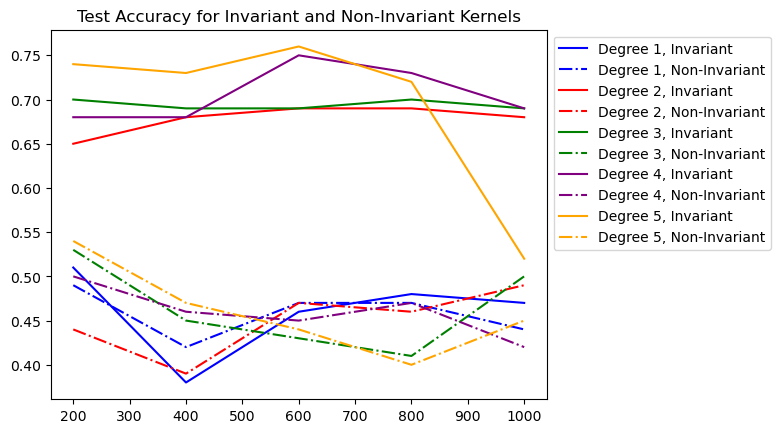

In [316]:
plt.plot(n_samples, invariant_test_acc[0], color='blue', label='Degree 1, Invariant')
plt.plot(n_samples, noninvariant_test_acc[0], '-.', color='blue', label='Degree 1, Non-Invariant')

plt.plot(n_samples, invariant_test_acc[1], color='red', label='Degree 2, Invariant')
plt.plot(n_samples, noninvariant_test_acc[1], '-.', color='red', label='Degree 2, Non-Invariant')

plt.plot(n_samples, invariant_test_acc[2], color='green', label='Degree 3, Invariant')
plt.plot(n_samples, noninvariant_test_acc[2], '-.', color='green', label='Degree 3, Non-Invariant')

plt.plot(n_samples, invariant_test_acc[3], color='purple', label='Degree 4, Invariant')
plt.plot(n_samples, noninvariant_test_acc[3], '-.', color='purple', label='Degree 4, Non-Invariant')

plt.plot(n_samples, invariant_test_acc[4], color='orange', label='Degree 5, Invariant')
plt.plot(n_samples, noninvariant_test_acc[4], '-.', color='orange', label='Degree 5, Non-Invariant')

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Test Accuracy for Invariant and Non-Invariant Kernels')


# X-Y Skew Classification

In [317]:
def xy_skew_data(n_samples, d_points):

    X = np.zeros((n_samples, d_points, 2))
    y = 2*np.random.binomial(1, 0.5, n_samples) - 1

    for i in range(n_samples):
        pc = np.random.randn(d_points, 2)

        if y[i] == 1:
            X[i] = pc @np.array([[1 ,0], [0, 2]])
        
        else:
            X[i] = pc @ np.array([[2 ,0], [0, 1]])

    return X, y

In [320]:
X, y = xy_skew_data(1100, 50)

train_X = X[:1000]
train_y = y[:1000]
test_X = X[1000:]
test_y = y[1000:]

In [348]:
np.savez('Data/xy_skew_train.npz', x=train_X, y=train_y)
np.savez('Data/xy-skew-test.npz', x=test_X, y=test_y)

In [393]:
avg_val_accuracies = np.load('Data/XY-Invariant-Classification-val-acc.npy')
best_lams = np.load('Data/XY-Invariant-Classification-lambda.npy')

            

In [396]:
avg_val_accuracies

array([[0.54, 0.52, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [332]:
non_avg_val_accuracies = np.zeros((5, 5))
non_best_lams = np.zeros((5, 5))

In [395]:
best_lams

array([[1.e-05, 1.e-05, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e-05, 1.e-05, 1.e-05, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]])

In [399]:
for i in range(4,len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetInvariantClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        val_accuracies = np.zeros((folds, len(lams)))

        if best_lams[i][j] == 0:
            fold = 0
            for train_index, test_index in kfold.split(X):
                now = datetime.now()

                current_time = now.strftime("%H:%M:%S")
                print("Current Time =", current_time)
                print('fold', fold)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                kernel_matrix = kernel.gram_matrix(train_data)
                prediction_matrix = kernel.matrix(val_data, train_data)

                for l in range(len(lams)):
                    alpha = np.linalg.solve(kernel_matrix + lams[l]*np.eye(kernel_matrix.shape[0]), train_values)
                    val_accuracies[fold][l] = 1 - np.count_nonzero(val_values - np.sign(prediction_matrix@alpha))/val_data.shape[0]

                fold += 1

            best_lam = lams[np.argmax(np.mean(val_accuracies, axis=0))]
            best_lams[i][j] = best_lam
            avg_val_accuracies[i][j] = np.max(np.mean(val_accuracies, axis=0))

            print('Best Avg. Accuracy \n', avg_val_accuracies)
            print('Best Lambda \n', best_lams)

            np.save('Data/XY-Invariant-Classification-val-acc.npy', avg_val_accuracies)
            np.save('Data/XY-Invariant-Classification-lambda.npy', best_lams)

Degree 5
200 Samples
Current Time = 21:37:52
fold 0


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


Current Time = 21:41:50
fold 1


100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


Current Time = 21:45:23
fold 2


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Current Time = 21:48:47
fold 3


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


Best Avg. Accuracy 
 [[0.54  0.52  0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [1.    1.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.995 0.    1.    0.    0.   ]]
Best Lambda 
 [[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 0.e+00 1.e-03 0.e+00 0.e+00]]
400 Samples
Current Time = 21:52:15
fold 0


100%|██████████| 100/100 [05:18<00:00,  3.18s/it]


Current Time = 22:05:40
fold 1


100%|██████████| 100/100 [05:20<00:00,  3.20s/it]


Current Time = 22:19:17
fold 2


100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


Current Time = 22:32:49
fold 3


100%|██████████| 100/100 [05:16<00:00,  3.16s/it]


Best Avg. Accuracy 
 [[0.54   0.52   0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [1.     1.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.995  0.9975 1.     0.     0.    ]]
Best Lambda 
 [[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-04 1.e-03 0.e+00 0.e+00]]
600 Samples
800 Samples
Current Time = 22:46:10
fold 0


100%|██████████| 200/200 [21:07<00:00,  6.34s/it]


Current Time = 23:41:07
fold 1


100%|██████████| 200/200 [20:43<00:00,  6.22s/it]


Current Time = 00:35:03
fold 2


100%|██████████| 200/200 [20:45<00:00,  6.23s/it]


Current Time = 01:27:29
fold 3


100%|██████████| 200/200 [21:23<00:00,  6.42s/it]


Best Avg. Accuracy 
 [[0.54   0.52   0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [1.     1.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.995  0.9975 1.     1.     0.    ]]
Best Lambda 
 [[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-04 1.e-03 1.e-04 0.e+00]]
1000 Samples
Current Time = 02:21:57
fold 0


100%|██████████| 250/250 [32:16<00:00,  7.75s/it]


Current Time = 03:43:24
fold 1


100%|██████████| 250/250 [32:03<00:00,  7.69s/it]


Current Time = 05:05:59
fold 2


100%|██████████| 250/250 [32:11<00:00,  7.73s/it]


Current Time = 06:29:00
fold 3


100%|██████████| 250/250 [33:48<00:00,  8.11s/it]


Best Avg. Accuracy 
 [[0.54   0.52   0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [1.     1.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.995  0.9975 1.     1.     0.999 ]]
Best Lambda 
 [[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-05 1.e-04 1.e-03 1.e-04 1.e-03]]


In [400]:
invariant_test_acc = np.load('Data/XY-Invariant-Classification-test-acc.npy')
noninvariant_test_acc = np.load('Data/XY-Non-Invariant-Classification-test-acc.npy')

In [354]:
invariant_test_acc_no_reg = np.zeros((5, 5))
noninvariant_test_acc_no_reg = np.zeros((5, 5))

In [405]:
for i in range(4, len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetClassification(50, 2, degs[i])
    #invkernel = SetInvariantClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        #if invariant_test_acc[i][j] == 0:

        kernel.train(X, y, 0)
        print(best_lams[4][j])
        #invkernel.train(X, y, best_lams[4][j])

        #invariant_test_acc[i][j] = invkernel.accuracy(test_X, test_y)
        noninvariant_test_acc[i][j] = kernel.accuracy(test_X, test_y)

        #print('Invariant Accuracy \n', invariant_test_acc)
        print('Non-Invariant Accuracy \n', noninvariant_test_acc)

        #np.save('Data/XY-Invariant-Classification-test-acc.npy', invariant_test_acc)
        np.save('Data/XY-Non-Invariant-Classification-test-acc.npy', noninvariant_test_acc)


Degree 5
200 Samples


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:03<00:00, 54.14it/s] 


1e-05


100%|██████████| 100/100 [00:03<00:00, 29.12it/s]


Non-Invariant Accuracy 
 [[0.42 0.5  0.44 0.54 0.54]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.59 0.58 0.59 0.63]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.54 0.54 0.   0.  ]]
400 Samples


100%|██████████| 400/400 [00:11<00:00, 34.99it/s] 


0.0001


100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Non-Invariant Accuracy 
 [[0.42 0.5  0.44 0.54 0.54]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.59 0.58 0.59 0.63]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.54 0.54 0.   0.  ]]
600 Samples


100%|██████████| 600/600 [00:13<00:00, 44.14it/s] 


0.001


100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


Non-Invariant Accuracy 
 [[0.42 0.5  0.44 0.54 0.54]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.59 0.58 0.59 0.63]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.54 0.54 0.   0.  ]]
800 Samples


100%|██████████| 800/800 [00:32<00:00, 24.47it/s] 


0.0001


100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Non-Invariant Accuracy 
 [[0.42 0.5  0.44 0.54 0.54]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.59 0.58 0.59 0.63]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.54 0.54 0.52 0.  ]]
1000 Samples


100%|██████████| 1000/1000 [00:46<00:00, 21.71it/s]


0.001


100%|██████████| 100/100 [00:08<00:00, 12.48it/s]

Non-Invariant Accuracy 
 [[0.42 0.5  0.44 0.54 0.54]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.59 0.58 0.59 0.63]
 [1.   1.   1.   1.   1.  ]
 [0.46 0.54 0.54 0.52 0.62]]


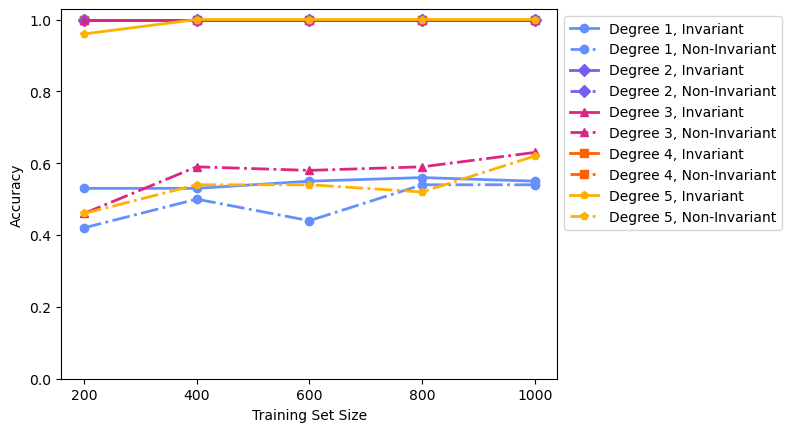

In [406]:
plt.plot(n_samples, invariant_test_acc[0], '-o', color='#648FFF', label='Degree 1, Invariant', linewidth=2)
plt.plot(n_samples, noninvariant_test_acc[0], '-.o', color='#648FFF', label='Degree 1, Non-Invariant', linewidth=2)

plt.plot(n_samples, invariant_test_acc[3], '-s', color='#FE6100', label='Degree 4, Invariant', linewidth=2)
plt.plot(n_samples, noninvariant_test_acc[3], '-.s', color='#FE6100', label='Degree 4, Non-Invariant', linewidth=2)

plt.plot(n_samples, invariant_test_acc[1], '-D', color='#775EF0', label='Degree 2, Invariant', linewidth=2)
plt.plot(n_samples, noninvariant_test_acc[1], '-.D', color='#775EF0', label='Degree 2, Non-Invariant', linewidth=2)

plt.plot(n_samples, invariant_test_acc[2], '-^', color='#DD2680', label='Degree 3, Invariant', linewidth=2)
plt.plot(n_samples, noninvariant_test_acc[2], '-.^', color='#DD2680', label='Degree 3, Non-Invariant', linewidth=2)

plt.plot(n_samples, invariant_test_acc[4], '-p', color='#FFB001', label='Degree 5, Invariant', linewidth=2)
plt.plot(n_samples, noninvariant_test_acc[4], '-.p', color='#FFB001', label='Degree 5, Non-Invariant', linewidth=2)

plt.legend()
plt.xlabel('Training Set Size')
plt.xticks([200, 400, 600, 800, 1000])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel('Accuracy')

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0, 1, 4, 5, 6, 7, 2, 3, 8, 9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1))
plt.savefig('Figures/xy-skew.pdf', bbox_inches='tight')

In [451]:
xy_inv = np.load('Data/XY-Invariant-Classification-test-acc.npy')
xy_non_inv = np.load('Data/XY-Non-Invariant-Classification-test-acc.npy')

snd_inv = np.load('Data/Multi-Invariant-Classification-test-acc.npy')
snd_non_inv = np.load('Data/Multi-Non-Invariant-Classification-test-acc.npy')

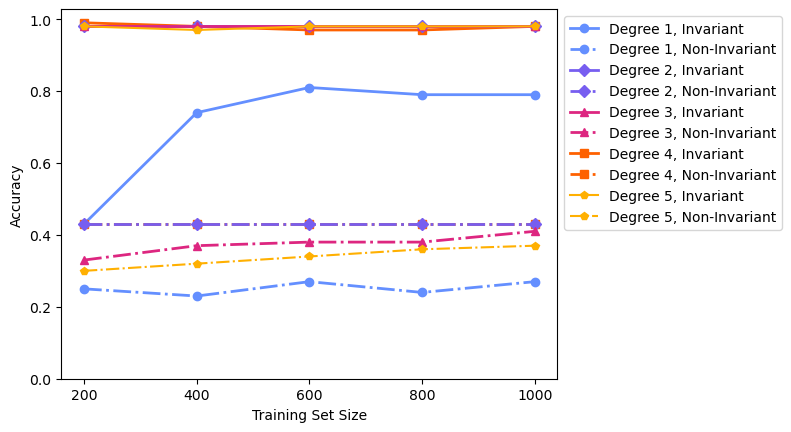

In [452]:
plt.plot(n_samples, snd_inv[0], '-o', color='#648FFF', label='Degree 1, Invariant', linewidth=2)
plt.plot(n_samples, snd_non_inv[0], '-.o', color='#648FFF', label='Degree 1, Non-Invariant', linewidth=2)

plt.plot(n_samples, snd_inv[3], '-s', color='#FE6100', label='Degree 4, Invariant', linewidth=2)
plt.plot(n_samples, snd_non_inv[3], '-.s', color='#FE6100', label='Degree 4, Non-Invariant', linewidth=2)

plt.plot(n_samples, snd_inv[1], '-D', color='#775EF0', label='Degree 2, Invariant', linewidth=2)
plt.plot(n_samples, snd_non_inv[1], '-.D', color='#775EF0', label='Degree 2, Non-Invariant', linewidth=2)

plt.plot(n_samples, snd_inv[2], '-^', color='#DD2680', label='Degree 3, Invariant', linewidth=2)
plt.plot(n_samples, snd_non_inv[2], '-.^', color='#DD2680', label='Degree 3, Non-Invariant', linewidth=2)

plt.plot(n_samples, snd_inv[4], '-p', color='#FFB001', label='Degree 5, Invariant')
plt.plot(n_samples, snd_non_inv[4], '-.p', color='#FFB001', label='Degree 5, Non-Invariant')

plt.legend()
plt.xlabel('Training Set Size')
plt.xticks([200, 400, 600, 800, 1000])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel('Accuracy')

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0, 1, 4, 5, 6, 7, 2, 3, 8, 9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1))
plt.savefig('Figures/multi-classification.pdf', bbox_inches='tight')
plt.show()

In [407]:
def multi_dist_data(n_samples, d_points):

    X = np.zeros((n_samples, d_points, 2))
    y = 2*np.random.binomial(1, 0.5, n_samples) - 1

    dists = [np.array([[2, 0], [0, 1]]), np.array([[1, 0], [0, 2]]), np.array([[2, 0], [0, 0.5]]), np.array([[1, 0.5], [0.5, 1]])]

    for i in range(n_samples):
        pc = np.random.randn(d_points, 2)

        if y[i] == 1:
            X[i] = pc
        
        else:
            i = np.random.randint(len(dists))
            X[i] = pc @ dists[i]

    return X, y

In [444]:
X, y = multi_dist_data(1000, 50)

In [445]:
#np.savez('Data/Multi-Classification-Train.npz', x=X[:1000], y=y[:1000])
np.savez('Data/Multi-Classification-Train.npz', x=X, y=y)


In [431]:
#train_X = X[:1000]
#train_y = y[:1000]
test_X = X
test_y = y

In [432]:
test_X.shape

(100, 50, 2)

In [421]:
best_lams = np.zeros((5, 5))
val_acc = np.zeros((5, 5))

In [422]:
for i in range(len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        val_accuracies = np.zeros((folds, len(lams)))

        if best_lams[i][j] == 0:
            fold = 0
            for train_index, test_index in kfold.split(X):
                now = datetime.now()

                current_time = now.strftime("%H:%M:%S")
                print("Current Time =", current_time)
                print('fold', fold)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                kernel_matrix = kernel.gram_matrix(train_data)
                prediction_matrix = kernel.matrix(val_data, train_data)

                for l in range(len(lams)):
                    alpha = np.linalg.solve(kernel_matrix + lams[l]*np.eye(kernel_matrix.shape[0]), train_values)
                    val_accuracies[fold][l] = 1 - np.count_nonzero(val_values - np.sign(prediction_matrix@alpha))/val_data.shape[0]

                fold += 1

            best_lam = lams[np.argmax(np.mean(val_accuracies, axis=0))]
            best_lams[i][j] = best_lam
            val_acc[i][j] = np.max(np.mean(val_accuracies, axis=0))

            print('Best Avg. Accuracy \n', val_acc)
            print('Best Lambda \n', best_lams)

            np.save('Data/Multi-Non-Invariant-Classification-val-acc.npy', val_acc)
            np.save('Data/Multi-Non-Invariant-Classification-lambda.npy', best_lams)

Degree 1
200 Samples
Current Time = 13:38:16
fold 0


100%|██████████| 50/50 [00:00<00:00, 85.60it/s]


Current Time = 13:38:18
fold 1


100%|██████████| 50/50 [00:00<00:00, 193.51it/s]


Current Time = 13:38:18
fold 2


100%|██████████| 50/50 [00:00<00:00, 215.69it/s]


Current Time = 13:38:19
fold 3


100%|██████████| 50/50 [00:00<00:00, 215.00it/s]


Best Avg. Accuracy 
 [[0.205 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
Best Lambda 
 [[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
400 Samples
Current Time = 13:38:20
fold 0


100%|██████████| 100/100 [00:01<00:00, 64.74it/s]


Current Time = 13:38:23
fold 1


100%|██████████| 100/100 [00:01<00:00, 99.04it/s]


Current Time = 13:38:26
fold 2


100%|██████████| 100/100 [00:01<00:00, 65.80it/s]


Current Time = 13:38:30
fold 3


100%|██████████| 100/100 [00:02<00:00, 44.33it/s]


Best Avg. Accuracy 
 [[0.205 0.23  0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
Best Lambda 
 [[1.e-05 1.e-01 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
600 Samples
Current Time = 13:38:35
fold 0


100%|██████████| 150/150 [00:02<00:00, 50.56it/s]


Current Time = 13:38:45
fold 1


100%|██████████| 150/150 [00:03<00:00, 44.83it/s]


Current Time = 13:38:54
fold 2


100%|██████████| 150/150 [00:02<00:00, 62.36it/s]


Current Time = 13:39:00
fold 3


100%|██████████| 150/150 [00:02<00:00, 71.11it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
800 Samples
Current Time = 13:39:06
fold 0


100%|██████████| 200/200 [00:03<00:00, 51.73it/s]


Current Time = 13:39:17
fold 1


100%|██████████| 200/200 [00:03<00:00, 55.66it/s]


Current Time = 13:39:27
fold 2


100%|██████████| 200/200 [00:04<00:00, 45.88it/s]


Current Time = 13:39:37
fold 3


100%|██████████| 200/200 [00:03<00:00, 51.55it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
1000 Samples
Current Time = 13:39:46
fold 0


100%|██████████| 250/250 [00:05<00:00, 49.24it/s]


Current Time = 13:40:01
fold 1


100%|██████████| 250/250 [00:05<00:00, 44.96it/s]


Current Time = 13:40:17
fold 2


100%|██████████| 250/250 [00:05<00:00, 48.54it/s]


Current Time = 13:40:31
fold 3


100%|██████████| 250/250 [00:05<00:00, 44.01it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Degree 2
200 Samples
Current Time = 13:40:45
fold 0


100%|██████████| 50/50 [00:00<00:00, 157.03it/s]


Current Time = 13:40:46
fold 1


100%|██████████| 50/50 [00:00<00:00, 109.00it/s]


Current Time = 13:40:47
fold 2


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


Current Time = 13:40:50
fold 3


100%|██████████| 50/50 [00:00<00:00, 139.25it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
400 Samples
Current Time = 13:40:51
fold 0


100%|██████████| 100/100 [00:02<00:00, 49.08it/s]


Current Time = 13:40:56
fold 1


100%|██████████| 100/100 [00:01<00:00, 82.07it/s]


Current Time = 13:40:59
fold 2


100%|██████████| 100/100 [00:01<00:00, 65.38it/s]


Current Time = 13:41:03
fold 3


100%|██████████| 100/100 [00:01<00:00, 81.86it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
600 Samples
Current Time = 13:41:07
fold 0


100%|██████████| 150/150 [00:02<00:00, 54.53it/s]


Current Time = 13:41:16
fold 1


100%|██████████| 150/150 [00:02<00:00, 54.98it/s]


Current Time = 13:41:23
fold 2


100%|██████████| 150/150 [00:02<00:00, 54.01it/s]


Current Time = 13:41:30
fold 3


100%|██████████| 150/150 [00:03<00:00, 47.22it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
800 Samples
Current Time = 13:41:38
fold 0


100%|██████████| 200/200 [00:04<00:00, 40.19it/s]


Current Time = 13:41:52
fold 1


100%|██████████| 200/200 [00:05<00:00, 35.13it/s]


Current Time = 13:42:06
fold 2


100%|██████████| 200/200 [00:04<00:00, 40.20it/s]


Current Time = 13:42:19
fold 3


100%|██████████| 200/200 [00:04<00:00, 41.67it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
1000 Samples
Current Time = 13:42:31
fold 0


100%|██████████| 250/250 [00:07<00:00, 31.95it/s]


Current Time = 13:42:54
fold 1


100%|██████████| 250/250 [00:07<00:00, 32.79it/s]


Current Time = 13:43:14
fold 2


100%|██████████| 250/250 [00:07<00:00, 31.55it/s]


Current Time = 13:43:34
fold 3


100%|██████████| 250/250 [00:07<00:00, 31.73it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Degree 3
200 Samples
Current Time = 13:43:55
fold 0


100%|██████████| 50/50 [00:01<00:00, 48.86it/s]


Current Time = 13:43:58
fold 1


100%|██████████| 50/50 [00:01<00:00, 49.37it/s]


Current Time = 13:44:00
fold 2


100%|██████████| 50/50 [00:00<00:00, 60.69it/s]


Current Time = 13:44:02
fold 3


100%|██████████| 50/50 [00:00<00:00, 105.16it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
400 Samples
Current Time = 13:44:04
fold 0


100%|██████████| 100/100 [00:02<00:00, 44.61it/s]


Current Time = 13:44:09
fold 1


100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Current Time = 13:44:15
fold 2


100%|██████████| 100/100 [00:01<00:00, 56.10it/s]


Current Time = 13:44:19
fold 3


100%|██████████| 100/100 [00:01<00:00, 57.64it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
600 Samples
Current Time = 13:44:24
fold 0


100%|██████████| 150/150 [00:05<00:00, 27.41it/s]


Current Time = 13:44:35
fold 1


100%|██████████| 150/150 [00:03<00:00, 41.03it/s]


Current Time = 13:44:46
fold 2


100%|██████████| 150/150 [00:03<00:00, 41.75it/s]


Current Time = 13:44:56
fold 3


100%|██████████| 150/150 [00:03<00:00, 39.73it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
800 Samples
Current Time = 13:45:06
fold 0


100%|██████████| 200/200 [00:06<00:00, 32.58it/s]


Current Time = 13:45:24
fold 1


100%|██████████| 200/200 [00:07<00:00, 28.50it/s]


Current Time = 13:45:41
fold 2


100%|██████████| 200/200 [00:06<00:00, 30.51it/s]


Current Time = 13:45:58
fold 3


100%|██████████| 200/200 [00:06<00:00, 30.05it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
1000 Samples
Current Time = 13:46:17
fold 0


100%|██████████| 250/250 [00:10<00:00, 24.54it/s]


Current Time = 13:46:43
fold 1


100%|██████████| 250/250 [00:10<00:00, 24.72it/s]


Current Time = 13:47:09
fold 2


100%|██████████| 250/250 [00:10<00:00, 24.98it/s]


Current Time = 13:47:35
fold 3


100%|██████████| 250/250 [00:09<00:00, 25.10it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Degree 4
200 Samples
Current Time = 13:48:00
fold 0


100%|██████████| 50/50 [00:01<00:00, 37.27it/s]


Current Time = 13:48:03
fold 1


100%|██████████| 50/50 [00:00<00:00, 86.62it/s]


Current Time = 13:48:05
fold 2


100%|██████████| 50/50 [00:00<00:00, 96.29it/s]


Current Time = 13:48:07
fold 3


100%|██████████| 50/50 [00:00<00:00, 78.20it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
400 Samples
Current Time = 13:48:08
fold 0


100%|██████████| 100/100 [00:02<00:00, 43.64it/s]


Current Time = 13:48:15
fold 1


100%|██████████| 100/100 [00:02<00:00, 41.32it/s]


Current Time = 13:48:22
fold 2


100%|██████████| 100/100 [00:02<00:00, 46.76it/s]


Current Time = 13:48:27
fold 3


100%|██████████| 100/100 [00:02<00:00, 49.94it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
600 Samples
Current Time = 13:48:33
fold 0


100%|██████████| 150/150 [00:04<00:00, 34.09it/s]


Current Time = 13:48:45
fold 1


100%|██████████| 150/150 [00:04<00:00, 32.76it/s]


Current Time = 13:48:57
fold 2


100%|██████████| 150/150 [00:04<00:00, 33.66it/s]


Current Time = 13:49:08
fold 3


100%|██████████| 150/150 [00:04<00:00, 33.60it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
800 Samples
Current Time = 13:49:19
fold 0


100%|██████████| 200/200 [00:09<00:00, 21.44it/s]


Current Time = 13:49:41
fold 1


100%|██████████| 200/200 [00:08<00:00, 24.38it/s]


Current Time = 13:50:01
fold 2


100%|██████████| 200/200 [00:07<00:00, 25.93it/s]


Current Time = 13:50:21
fold 3


100%|██████████| 200/200 [00:07<00:00, 26.07it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.        ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
1000 Samples
Current Time = 13:50:42
fold 0


100%|██████████| 250/250 [00:11<00:00, 21.24it/s]


Current Time = 13:51:13
fold 1


100%|██████████| 250/250 [00:11<00:00, 21.42it/s]


Current Time = 13:51:45
fold 2


100%|██████████| 250/250 [00:12<00:00, 20.74it/s]


Current Time = 13:52:16
fold 3


100%|██████████| 250/250 [00:12<00:00, 19.93it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.         0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Degree 5
200 Samples
Current Time = 13:52:50
fold 0


100%|██████████| 50/50 [00:01<00:00, 48.55it/s]


Current Time = 13:52:52
fold 1


100%|██████████| 50/50 [00:01<00:00, 46.45it/s]


Current Time = 13:52:55
fold 2


100%|██████████| 50/50 [00:00<00:00, 65.80it/s]


Current Time = 13:52:57
fold 3


100%|██████████| 50/50 [00:00<00:00, 60.08it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.305      0.         0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]]
400 Samples
Current Time = 13:52:59
fold 0


100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


Current Time = 13:53:07
fold 1


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Current Time = 13:53:13
fold 2


100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Current Time = 13:53:21
fold 3


100%|██████████| 100/100 [00:02<00:00, 37.54it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.305      0.415      0.         0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 0.e+00 0.e+00 0.e+00]]
600 Samples
Current Time = 13:53:27
fold 0


100%|██████████| 150/150 [00:05<00:00, 29.64it/s]


Current Time = 13:53:42
fold 1


100%|██████████| 150/150 [00:05<00:00, 27.88it/s]


Current Time = 13:53:56
fold 2


100%|██████████| 150/150 [00:05<00:00, 26.23it/s]


Current Time = 13:54:11
fold 3


100%|██████████| 150/150 [00:05<00:00, 27.01it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.305      0.415      0.42       0.         0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 0.e+00 0.e+00]]
800 Samples
Current Time = 13:54:25
fold 0


100%|██████████| 200/200 [00:09<00:00, 20.45it/s]


Current Time = 13:54:52
fold 1


100%|██████████| 200/200 [00:09<00:00, 22.20it/s]


Current Time = 13:55:16
fold 2


100%|██████████| 200/200 [00:09<00:00, 21.58it/s]


Current Time = 13:55:40
fold 3


100%|██████████| 200/200 [00:09<00:00, 21.64it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.305      0.415      0.42       0.44875    0.        ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 0.e+00]]
1000 Samples
Current Time = 13:56:03
fold 0


100%|██████████| 250/250 [00:15<00:00, 15.95it/s]


Current Time = 13:56:44
fold 1


100%|██████████| 250/250 [00:14<00:00, 17.07it/s]


Current Time = 13:57:22
fold 2


100%|██████████| 250/250 [00:14<00:00, 16.94it/s]


Current Time = 13:58:01
fold 3


100%|██████████| 250/250 [00:14<00:00, 16.77it/s]


Best Avg. Accuracy 
 [[0.205      0.23       0.22666667 0.2475     0.256     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.355      0.44       0.45833333 0.48875    0.495     ]
 [0.505      0.4975     0.50666667 0.5275     0.52      ]
 [0.305      0.415      0.42       0.44875    0.445     ]]
Best Lambda 
 [[1.e-05 1.e-01 1.e-05 1.e-01 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]


In [449]:
invariant_test_acc = np.zeros((5, 5))
noninvariant_test_acc = np.zeros((5, 5))

invariant_lams = np.load('Data/Multi-Invariant-Classification-lambda.npy')
noninvariant_lams = np.load('Data/Multi-Non-Invariant-Classification-lambda.npy')

In [446]:
data = np.load('Data/Multi-Classification-Train.npz')
train_X =data['x']
train_y = data['y']

data = np.load('Data/Multi-Classification-Test.npz')
test_X =data['x']
test_y = data['y']

In [447]:
train_y.shape

(1000,)

In [450]:
for i in range(len(degs)):

    print(f'Degree {degs[i]}')
    kernel = SetClassification(50, 2, degs[i])
    invkernel = SetInvariantClassification(50, 2, degs[i])

    for j in range(len(n_samples)):
        print(f'{n_samples[j]} Samples')
        X = train_X[:n_samples[j]]
        y = train_y[:n_samples[j]]

        inv_lam = invariant_lams[i][j]
        noninv_lam = noninvariant_lams[i][j]

        if invariant_test_acc[i][j] == 0:

            kernel.train(X, y, noninv_lam)
            invkernel.train(X, y, inv_lam)

            invariant_test_acc[i][j] = invkernel.accuracy(test_X, test_y)
            noninvariant_test_acc[i][j] = kernel.accuracy(test_X, test_y)

            print('Invariant Accuracy \n', invariant_test_acc)
            print('Non-Invariant Accuracy \n', noninvariant_test_acc)

            np.save('Data/Multi-Invariant-Classification-test-acc.npy', invariant_test_acc)
            np.save('Data/Multi-Non-Invariant-Classification-test-acc.npy', noninvariant_test_acc)

Degree 1
200 Samples


100%|██████████| 100/100 [00:00<00:00, 162.02it/s]


Invariant Accuracy 
 [[0.43 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:01<00:00, 83.24it/s]


Invariant Accuracy 
 [[0.43 0.74 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:01<00:00, 51.06it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:02<00:00, 40.86it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
1000 Samples


100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Degree 2
200 Samples


100%|██████████| 100/100 [00:00<00:00, 139.27it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:01<00:00, 64.73it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:02<00:00, 44.71it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
1000 Samples


100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Degree 3
200 Samples


100%|██████████| 100/100 [00:01<00:00, 97.67it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:01<00:00, 53.90it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:04<00:00, 24.03it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
1000 Samples


100%|██████████| 100/100 [00:05<00:00, 19.90it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Degree 4
200 Samples


100%|██████████| 100/100 [00:01<00:00, 89.26it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:03<00:00, 32.58it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.  ]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.  ]
 [0.   0.   0.   0.   0.  ]]
1000 Samples


100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.   0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.   0.   0.   0.   0.  ]]
Degree 5
200 Samples


100%|██████████| 100/100 [00:01<00:00, 63.46it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.98 0.   0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.3  0.   0.   0.   0.  ]]
400 Samples


100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.98 0.97 0.   0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.3  0.32 0.   0.   0.  ]]
600 Samples


100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.98 0.97 0.98 0.   0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.3  0.32 0.34 0.   0.  ]]
800 Samples


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.98 0.97 0.98 0.98 0.  ]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.3  0.32 0.34 0.36 0.  ]]
1000 Samples


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


Invariant Accuracy 
 [[0.43 0.74 0.81 0.79 0.79]
 [0.98 0.98 0.98 0.98 0.98]
 [0.98 0.98 0.98 0.98 0.98]
 [0.99 0.98 0.97 0.97 0.98]
 [0.98 0.97 0.98 0.98 0.98]]
Non-Invariant Accuracy 
 [[0.25 0.23 0.27 0.24 0.27]
 [0.43 0.43 0.43 0.43 0.43]
 [0.33 0.37 0.38 0.38 0.41]
 [0.43 0.43 0.43 0.43 0.43]
 [0.3  0.32 0.34 0.36 0.37]]


In [443]:
train_X.shape

(200, 50, 2)

# Generalization Across Dimensions

Learning the norm in different dimensions.

Train in dimension $d=50.$ Test to $d=500$ in increments of 50.

In [4]:
from invariant_kernels import InvariantTF, NonInvariantTF

In [125]:
def norm_data(n_samples, d_dimension):

    X = np.zeros((n_samples, d_dimension))
    y = np.zeros(n_samples)

    for i in range(n_samples):

        v = np.random.randn(d_dimension)
        X[i] = v
        y[i] = np.linalg.norm(v)**2

    return X, y

In [126]:
for i in range(1, 21):

    X, y = norm_data(200, i*10)

    np.savez(f'Data/Norm-Data/squared-d{i*10}-test.npz',  x=X, y=y)

In [178]:
X, y = norm_data(2000, 50)
np.savez('Data/Norm-Data/squared-d50-train.npz', x=X, y=y)

In [179]:
data=np.load('Data/Norm-Data/squared-d50-train.npz')
train_X = data['x']
train_y = data['y']

In [187]:
degs = [1, 2, 3, 4, 5]
lams = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

val_acc = np.zeros(5)
best_lams = np.zeros(5)

In [169]:
folds  = 4

kfold = KFold(n_splits=folds)

In [188]:
for i in range(1, len(degs)):

    print(f'Degree {degs[i]}')
    kernel = InvariantTF(50, degs[i])

    X = train_X
    y = train_y

    val_accuracies = np.zeros((folds, len(lams)))

    if best_lams[i] == 0:
        fold = 0
        for train_index, test_index in kfold.split(X):
            now = datetime.now()

            current_time = now.strftime("%H:%M:%S")
            print("Current Time =", current_time)
            print('fold', fold)

            train_data = X[train_index]
            train_values = y[train_index]
            val_data = X[test_index]
            val_values = y[test_index]

            kernel_matrix = kernel.gram_matrix(train_data)
            prediction_matrix = kernel.matrix(val_data, train_data)
            #print(prediction_matrix.shape)
            #print(kernel_matrix.shape)

            for l in range(len(lams)):
                alpha = np.linalg.solve(kernel_matrix + lams[l]*np.eye(kernel_matrix.shape[0]), train_values)
                val_accuracies[fold][l] = np.mean((val_values - prediction_matrix@alpha)**2/val_values)

            fold += 1

            print(val_accuracies)

        best_lam = lams[np.argmin(np.mean(val_accuracies, axis=0))]
        best_lams[i] = best_lam
        val_acc[i] = np.min(np.mean(val_accuracies, axis=0))

        #kernel.train(X, y, best_lam)
        #print(kernel.training_error)
        
        print('Best Avg. Accuracy \n', val_acc)
        print('Best Lambda \n', best_lams)

        np.save('Data/Norm-Data/squared-d50-invariant-lambda.npy', best_lams)
        np.save('Data/Norm-Data/squared-d50-invariant-val-acc.npy', val_acc)

Degree 2
Current Time = 10:37:54
fold 0


100%|██████████| 3/3 [00:00<00:00, 53.04it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1500 is different from 500)

In [183]:
val_accuracies

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
np.save('Data/Norm-Data/d10-lambda.npy', best_lams)
np.save('Data/Norm-Data/d10-val-acc.npy', val_acc)

In [90]:
test_acc = np.zeros((5, 20))

In [31]:
np.save('Data/Norm-Data/d50-test-error.npy', test_acc)

In [140]:
best_lams=np.load('Data/Norm-Data/squared-d50-invariant-lambda.npy')

In [141]:
data = np.load('Data/Norm-Data/squared-d50-train.npz')
train_X = data['x']
train_y = data['y']

In [210]:
test_acc=np.zeros((5, 20))

In [212]:
for j in range(2, 3):

    data = np.load('Data/Norm-Data/squared-d50-train.npz')
    train_X = data['x']
    train_y = data['y']

    kernel = InvariantTF(50, j)
    kernel.train(train_X, train_y, 1e-5)
    alpha = kernel.alpha

    for i in range(1, 21):
        d = i*10

        test_data = np.load(f'Data/Norm-Data/squared-d{d}-test.npz')
        test_X = test_data['x']
        test_y = test_data['y']

        #print(f"Dimension {d}, Degree {j}")

        if d < 50:
            test_X = np.pad(test_X, ((0,0), (0, 50-d)), 'constant')
                #print(test_X.shape)

        elif d>50:
            train_X = np.pad(train_X, ((0,0), (0, 10)), 'constant')
        
        #print('Train Shape:', train_X.shape)
        #print("Test Shape:", test_X.shape)

        kernel = InvariantTF(d, j)
        prediction_matrix = kernel.matrix(train_X, test_X)
        #prediction_matrix = kernel.matrix(test_X, train_X)
        test_acc[j-1][i-1] = np.mean((test_y - prediction_matrix@alpha)**2/test_y)
    print(test_acc)

    np.save('Data/Norm-Data/squared-d50-10-200-invariant-test-error.npy', test_acc)

100%|██████████| 3/3 [00:00<00:00, 18.84it/s]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.36163200e+00 7.84754520e+00 5.20162452e+00 2.19587351e+00
  2.63789051e-20 3.41241066e-20 7.12389424e-20 1.15578895e-19
  2.01660776e-19 2.81922968e-19 3.65002353e-19 4.19362365e-19
  5.37234347e-19 6.28091962e-19 6.97944764e-19 8.16235519e-19
  9.19376393e-19 1.00788405e-18 1.08148145e-18 1.19653351e-18]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0

In [68]:
test_acc

array([[3.11144470e+00, 4.40424240e+00, 5.48802340e+00, 6.35212516e+00,
        6.99082246e+00, 7.89704947e+00, 8.31229165e+00, 8.98573643e+00,
        9.43037003e+00, 9.98930951e+00, 1.04992310e+01, 1.08890982e+01,
        1.13233408e+01, 1.17920094e+01, 1.21463139e+01, 1.27017234e+01,
        1.30665274e+01, 1.32983832e+01, 1.38058190e+01, 1.41025861e+01],
       [1.49373985e-01, 7.80515009e-01, 1.39034204e+00, 2.00841029e+00,
        7.68074752e-01, 1.53659835e+00, 2.13978318e+00, 3.17569155e+00,
        4.28981708e+00, 5.30075967e+00, 6.76812548e+00, 8.08813124e+00,
        9.83467503e+00, 1.16641508e+01, 1.33267235e+01, 1.56365723e+01,
        1.77993427e+01, 1.97974905e+01, 2.29775384e+01, 2.55472215e+01],
       [3.21425151e-03, 2.44985118e-02, 1.73509988e-01, 4.26419158e-01,
        7.71615904e-01, 1.55793326e+00, 2.17959953e+00, 3.20683792e+00,
        4.31842461e+00, 5.27635133e+00, 6.91201764e+00, 8.14690943e+00,
        9.92397163e+00, 1.17775581e+01, 1.33915219e+01, 1.5799

In [93]:
for i in range(5, 21):

    d = i*10
    print(f'Dimension {d}')

    data = np.load(f'Data/Norm-Data/d{d}-test.npz')
    test_X = data['x']
    test_y = data['y']
    
    if d < 50:
        test_X = np.pad(test_X, ((0,0), (0, 50-d)), 'constant')
                #print(test_X.shape)

    elif d>50:
        train_X = np.pad(train_X, ((0,0), (0, 10)), 'constant')
    
    print('Train Shape:', train_X.shape)
    print("Test Shape:", test_X.shape)

    for j in range(1, 6):
        print(f'Degree {j}')
        kernel = InvariantTF(d, j)

        if test_acc[j-1][i-1] ==0:

            kernel.train(train_X, train_y, best_lams[j-1])
            test_acc[j-1][i-1] = kernel.relative_error(test_X, test_y)

            print('Test Error \n', test_acc)
            np.save('Data/Norm-Data/d50-test-error.npy', test_acc)





Dimension 50
Train Shape: (500, 50)
Test Shape: (200, 50)
Degree 1


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 179.08it/s]


Test Error 
 [[0.         0.         0.         0.         0.01212495 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0

100%|██████████| 3/3 [00:00<00:00, 124.73it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 6/6 [00:00<00:00, 178.83it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 11/11 [00:00<00:00, 148.94it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 18/18 [00:00<00:00, 182.48it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 1/1 [00:00<00:00, 79.57it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 1.73141041e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 3/3 [00:00<00:00, 121.21it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 1.73141041e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 1.47762259e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 6/6 [00:00<00:00, 192.44it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 1.73141041e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 1.47762259e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 1.54642963e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

100%|██████████| 11/11 [00:00<00:00, 188.81it/s]


Test Error 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.21249521e-02 1.73141041e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.06844263e-05 1.47762259e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.84995219e-05 1.54642963e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

  3%|▎         | 13/500 [00:12<07:37,  1.06it/s]


KeyboardInterrupt: 

In [204]:
invariant_test_acc=np.load('Data/Norm-Data/squared-d50-invariant-test-error.npy')
noninvariant_test_acc= np.load('Data/Norm-Data/squared-d50-noninvariant-test-error.npy')

In [196]:
invariant_test_acc=invariant_test_acc[:,1:]
noninvariant_test_acc=noninvariant_test_acc[:,1:]

In [197]:
import matplotlib.pyplot as plt

In [205]:
invariant_test_acc[1]

array([2.63789051e-20, 3.41241066e-20, 7.12389424e-20, 1.15578895e-19,
       2.01660776e-19, 2.81922968e-19, 3.65002353e-19, 4.19362365e-19,
       5.37234347e-19, 6.28091962e-19, 6.97944764e-19, 8.16235519e-19,
       9.19376393e-19, 1.00788405e-18, 1.08148145e-18, 1.19653351e-18])

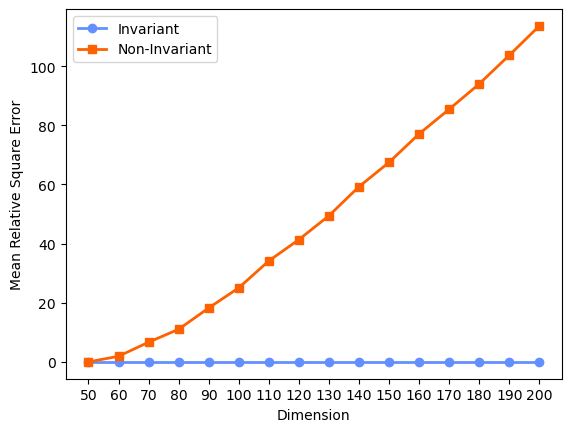

In [222]:
plt.plot(range(50, 201, 10), invariant_test_acc[1], '-o', color='#648FFF', label='Invariant', linewidth=2)
plt.plot(range(50, 201, 10), noninvariant_test_acc[1], '-s', color='#FE6100', label='Non-Invariant', linewidth=2)
plt.xlabel('Dimension')
plt.xticks(range(50, 201, 10))
plt.ylabel('Mean Relative Square Error')
plt.legend()
plt.savefig('Figures/norm-generalization.pdf')